# Hedley_2005_glint_correction

__What does this notebook do?__ This notebook corrects for sun glints over deep ocean using the Hedley (2005) correction method. There are a number of calculations included, so that your correction can be evaluated graphically for the area of interest. The notebook is divided into the following sections:
1. Load data for your area of interest ???what to do with areas with atolls!? add a nice thing to select an area
2. Identify glinted pixels in the area
3. Correct for glint
4. Plot reflectance values for different pixels for a visual check of if the correction is working
5. Load true-colour images to show glint correction
6. Export geotiffs of uncorrected and corrected data

__Date:__ April 2018

__Author:__ Snowy Haiblen (written during a graduate rotation, feel free to contact me for furter info (Anna.Haiblen@ga.gov.au))

## Load modules

In [65]:
# Import modules
import datacube
import numpy as np
import matplotlib.pyplot as plt
import pandas
import xarray as xr
from matplotlib.pyplot import imshow
from skimage import exposure
from datacube.storage import masking
from sklearn.linear_model import LinearRegression

# Import DEA Notebooks scripts


# Set up datacube instance
dc = datacube.Datacube(app='load-data-example')

## User inputs: area of interest, product, time range, and image of interest within time range

In [66]:
# Enter details of the imagery that you are interested in here. 

# Area of interest:
lat_min = -11.75 #up
lat_max = -11.85 #down
lon_min = 143.76 #left
lon_max = 143.86 #right

# Product (eg. 'ls8_nbar_albers'), and related pixel quality (pq) product (eg. 'ls8_pq_albers')
product = 'ls8_nbar_albers'
pq_product = 'ls8_pq_albers'

# Time range of interest ('yyyy-mm-dd')
start = '2016-01-01'
end = '2017-01-01'

# Image to correct for glint within specified time range (numbered by date order, first image = 0)
image = 0

## Load bands and correct for no data pixels, cloud, and image overlap

Total number of images and image size:  (46, 473, 484)
Image size and number of cloud free images:  (473, 484, 1)


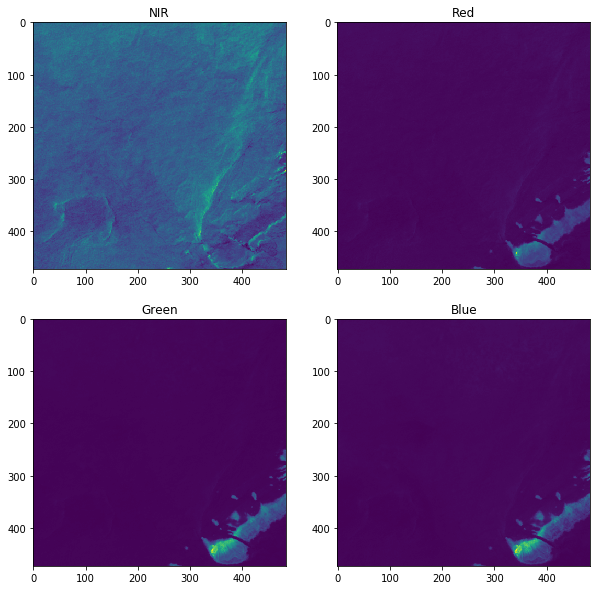

In [67]:
# Load data for a specified area and time grouped by solar day
data = dc.load(product= product, 
               x=(lon_min, lon_max), y=(lat_min, lat_max),
               time=(start, end), group_by='solar_day')

# Define variables
nir = data.nir.isel(time=image)
red = data.red.isel(time=image)
blue = data.blue.isel(time=image)
green = data.green.isel(time=image)

# Find out how many images are available
print("Total number of images and image size: ", data.nir.shape)

# Remove no data pixels and plot images with clouds
nir_valid = nir.where(nir != nir.attrs['nodata'])
red_valid = red.where(red != red.attrs['nodata'])
blue_valid = blue.where(blue != blue.attrs['nodata'])
green_valid = green.where(green != green.attrs['nodata'])

# Load pixel quality data for the same area and time
pq = dc.load(product = pq_product, 
               x=(lon_min, lon_max), y=(lat_min, lat_max),
               time=(start, end), group_by='solar_day')
pq_toplot = pq.pixelquality

# Create a dataframe for masking bad data
pandas.DataFrame.from_dict(masking.get_flags_def(pq), orient='index')

# Mask out the bad data
good_data = masking.make_mask(pq, cloud_acca='no_cloud', cloud_fmask='no_cloud', contiguous=True)
toplot_good_data = good_data.pixelquality

# Apply the mask to give good data with clouded pixels represented by NaN
nir_cloud_free = nir_valid.where(toplot_good_data)
red_cloud_free = red_valid.where(toplot_good_data)
blue_cloud_free = blue_valid.where(toplot_good_data)
green_cloud_free = green_valid.where(toplot_good_data)

# Find only the images in the time series that are cloud free, then return the number of cloud-free images
cloud_free = masking.make_mask(pq, cloud_acca='no_cloud', cloud_fmask='no_cloud', contiguous=True).pixelquality
only_cloud_free = cloud_free.mean(dim=('x','y')) == 1
nir_only_cloud_free = nir_cloud_free.where(only_cloud_free).dropna('time', how='all')
red_only_cloud_free = red_cloud_free.where(only_cloud_free).dropna('time', how='all')
blue_only_cloud_free = blue_cloud_free.where(only_cloud_free).dropna('time', how='all')
green_only_cloud_free = green_cloud_free.where(only_cloud_free).dropna('time', how='all')
print ("Image size and number of cloud free images: ", nir_only_cloud_free.shape)

# Plot nir and r,g,b for the area for the specified time
plt.figure(figsize = (10,10))
plt.subplot(221)
plt.title ('NIR')
imshow(nir_only_cloud_free.isel(time=image))
plt.subplot(222)
plt.title('Red')
imshow(red_only_cloud_free.isel(time=image))
plt.subplot(223)
plt.title ('Green')
imshow(green_only_cloud_free.isel(time=image))
plt.subplot(224)
plt.title('Blue')
imshow(blue_only_cloud_free.isel(time=image))

## Select deep-sea area within image to base glint correction on

### Grid the image and select which portions are 100% deep ocean

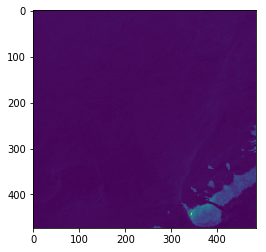

In [68]:
imshow(red_only_cloud_free.isel(time=image))

In [73]:
red_only_cloud_free.crs

CRS('EPSG:3577')

Map(basemap={'url': 'http://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}', 'max_zoom': 20, 'attribution': 'Tiles &copy; Esri &mdash; Source: Esri, i-cubed, USDA, USGS, AEX, GeoEye, Getmapping, Aerogrid, IGN, IGP, UPR-EGP, and the GIS User Community', 'name': 'Esri.WorldImagery'}, center=[-11.8, 143.81], controls=(DrawControl(layer=FeatureGroup(), polygon={'shapeOptions': {}}),), default_tiles=TileLayer(attribution='Tiles &copy; Esri &mdash; Source: Esri, i-cubed, USDA, USGS, AEX, GeoEye, Getmapping, Aerogrid, IGN, IGP, UPR-EGP, and the GIS User Community', max_zoom=20, min_zoom=1, name='Esri.WorldImagery', options=['attribution', 'detect_retina', 'max_zoom', 'min_zoom', 'opacity', 'tile_size'], url='http://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}'), layers=(TileLayer(attribution='Tiles &copy; Esri &mdash; Source: Esri, i-cubed, USDA, USGS, AEX, GeoEye, Getmapping, Aerogrid, IGN, IGP, UPR-EGP, and the GIS User Community', max_zoom=20, min_zoom=1, name='Esri.WorldImagery', options=['attribution', 'detect_retina', 'max_zoom', 'min_zoom', 'opacity', 'tile_size'], url='http://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}'),), layout=Layout(height='400px', width='400px'), options=['attribution_control', 'basemap', 'bounce_at_zoom_limits', 'box_zoom', 'center', 'close_popup_on_click', 'double_click_zoom', 'dragging', 'inertia', 'inertia_deceleration', 'inertia_max_speed', 'keyboard', 'keyboard_pan_offset', 'keyboard_zoom_offset', 'max_zoom', 'min_zoom', 'scroll_wheel_zoom', 'tap', 'tap_tolerance', 'touch_zoom', 'world_copy_jump', 'zoom', 'zoom_animation_threshold', 'zoom_control', 'zoom_start'])

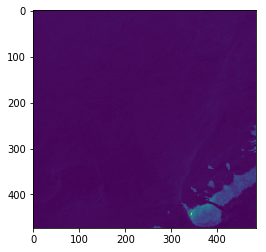

In [247]:
from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl,
    basemaps
)

import plotly.plotly as py
from traitlets import link
import ipywidgets as widgets
from datacube.utils import geometry
# lat_min = -11.75 #up
# lat_max = -11.85 #down
# lon_min = 143.76 #left
# lon_max = 143.86 #right
center = [(lat_min + ((lat_max - lat_min)/2)), (lon_min + ((lon_max - lon_min)/2))]
lat_mid = lat_min + ((lat_max - lat_min)/2)
lon_mid = lon_min + ((lon_max - lon_min)/2)
zoom = 12

m = Map(projection='aea', center=center, zoom=zoom,layout=dict(width='400px', height='400px'),basemap=basemaps.Esri.WorldImagery)

# m = Map(projection='lcc', resolution=None, width=8E6, height=8E6, lat_0=45, lon_0=-100, layout=dict(width='400px', height='400px'), basemap=basemaps.Esri.WorldImagery)

# m = Map(center=center, zoom=zoom,layout=dict(width='400px', height='400px'),basemap=red_only_cloud_free.isel(time=image))

#m.bounds = [(-12.118550864498046, 143.58581542968753),(-11.580942829520456, 144.13513183593753)]


# Now create the DrawControls and add it to the Maps using add_control. 
# (there are the actions). The geo_json argument is the serialized geometry of the drawn path, 
# along with its embedded style.

draw_control = DrawControl(polyline={})

#add draw controls to maps

m.add_control(draw_control)
display(m)

imshow(red_only_cloud_free.isel(time=image))


In [222]:
from shapely.geometry import Polygon



KeyError: 0

In [226]:
geom_crs = geometry.CRS('EPSG:4326') 

try:
    GEOM=geometry.Geometry(draw_control.last_draw['geometry'], geom_crs)
except:
    print("Draw a polygon first.")

draw_control.last_draw['geometry']

{'coordinates': [[[143.751228, -11.775455],
   [143.79174, -11.815784],
   [143.817833, -11.765372],
   [143.795174, -11.745204],
   [143.762215, -11.745877],
   [143.751228, -11.775455]]],
 'type': 'Polygon'}

In [248]:
from shapely.geometry import mapping, Polygon
import fiona
schema = {
   'geometry': 'Polygon',
   'properties': {'id': 'int',
                   'name': 'str'},
}
coords = draw_control.last_draw['geometry']['coordinates']
output_shpfile = '/g/data/u46/users/ah3144/dea-notebooks/Glint.shp'
try:
   with fiona.open(output_shpfile, 'w', 'ESRI Shapefile', schema, crs = {'init': 'epsg:4326', 'no_defs': True}) as c:  
       c.write({
             'geometry': mapping(Polygon(coords[0])),
             'properties': {'id': 1,
                            'name': 'drawn_polygon'},
         })
except:
   print(c.closed)
   raise
c.closed

True

In [249]:
red_only_cloud_free.isel(time=image).crs


CRS('EPSG:3577')

In [245]:
[i.split(' ') for i in GEOM.wkt[10:-2].split(',')]

[['143.751228', '-11.775455'],
 ['143.79174', '-11.815784'],
 ['143.817833', '-11.765372'],
 ['143.795174', '-11.745204'],
 ['143.762215', '-11.745877'],
 ['143.751228', '-11.775455']]

In [201]:
def get_date(self):
        for row in self.GEOM:
            d = row[0]
            return d

def dates(self):
    dates = []
    for row in dates:
        date = row.get_date()
        if date not in dates:
            dates.append(date)
    return sorted(dates)

print (d)

NameError: name 'd' is not defined

In [239]:
from osgeo import ogr
from shapely.geometry import Polygon

# Here's an example Shapely geometry
#poly = Polygon([(0, 0), (0, 1), (1, 1), (0, 0)])
import json
import geojson
from shapely.geometry import shape

o = {'coordinates': [[[143.751228, -11.775455],
   [143.79174, -11.815784],
   [143.817833, -11.765372],
   [143.795174, -11.745204],
   [143.762215, -11.745877],
   [143.751228, -11.775455]]],
 'type': 'Polygon'}

s = json.dumps(o)

# Convert to geojson.geometry.Polygon
g1 = geojson.loads(s)

# Feed to shape() to convert to shapely.geometry.polygon.Polygon
# This will invoke its __geo_interface__ (https://gist.github.com/sgillies/2217756)
g2 = shape(g1)
poly =g2
# Now convert it to a shapefile with OGR    
driver = ogr.GetDriverByName('Esri Shapefile')
ds = driver.CreateDataSource('my.shp')
layer = ds.CreateLayer('', None, ogr.wkbPolygon)
# Add one attribute
layer.CreateField(ogr.FieldDefn('id', ogr.OFTInteger))
defn = layer.GetLayerDefn()

## If there are multiple geometries, put the "for" loop here

# Create a new feature (attribute and geometry)
feat = ogr.Feature(defn)
feat.SetField('id', 123)

# Make a geometry, from Shapely object
geom = ogr.CreateGeometryFromWkb(poly.wkb)
feat.SetGeometry(geom)

layer.CreateFeature(feat)
# feat = geom = None  # destroy these

# Save and close everything
# ds = layer = feat = geom = None

layer

ModuleNotFoundError: No module named 'geojson'

In [213]:
from osgeo import ogr
import gdal
# Create ring
ring = ogr.Geometry(ogr.wkbLinearRing)
ring.AddPoint(143.809971, -11.783342)
ring.AddPoint(143.803104, -11.815268)
ring.AddPoint(143.854603, -11.814596)
ring.AddPoint(143.848423, -11.789727)
ring.AddPoint(143.809971, -11.783342)

# Create polygon
poly = ogr.Geometry(ogr.wkbPolygon)
poly.AddGeometry(ring)

# print poly.ExportToWkt()
print(poly)
# type(poly)
# plt.plot(poly)

POLYGON ((143.809971 -11.783342 0,143.803104 -11.815268 0,143.854603 -11.814596 0,143.848423 -11.789727 0,143.809971 -11.783342 0))


In [250]:
########################################
#Rasterize shapefile vector for masking
########################################

#find the 'wkt' for GDA94 Albers Equal Area
import osr
srs = osr.SpatialReference()
srs.ImportFromEPSG(3577)
prj_wkt = srs.ExportToWkt()

#find the width and height of the xarray dataset we want to mask
width,height = nir_only_cloud_free.isel(time=image).shape

#location of the shapefile we're converting
# project_area_CEA_albers_loc = data + project_ID + '_cea_albers.shp'

#create 'transform' tuple that will define the dimensions of the rasterized shapefile
easting = float(nir_only_cloud_free.x[0])
W_E_pixelRes = float(nir_only_cloud_free.y[0] - nir_only_cloud_free.y[1])
rotation = 0.0 #(if image is 'north up')
northing = float(nir_only_cloud_free.y[0])
rotation1 = 0.0 #(if image is 'north up')
N_S_pixelRes = float(nir_only_cloud_free.x[0] - nir_only_cloud_free.x[1])
transform = (easting, W_E_pixelRes, rotation, northing, rotation1, N_S_pixelRes)

def rasterize_vector(input_data, cols, rows, geo_transform,
                     projection, field=None, raster_path=None):
    """
    Rasterize a vector file and return an array with values for cells that occur within the shapefile. 
    This function is loaded as a module but for some wierd reason isn't working: 'module uncallable'
    """

    # If input data is a string, import as shapefile layer
    if isinstance(input_data, str):
        # Open vector with gdal
        data_source = gdal.OpenEx(input_data, gdal.OF_VECTOR)
        input_data = data_source.GetLayer(0)
    # If raster path supplied, save rasterized file as a geotiff
    if raster_path:
        # Set up output raster
        print('Exporting raster to {}'.format(raster_path))
        driver = gdal.GetDriverByName('GTiff')
        target_ds = driver.Create(raster_path, cols, rows, 1, gdal.GDT_UInt16)
    else:
        # If no raster path, create raster as memory object
        driver = gdal.GetDriverByName('MEM')  # In memory dataset
        target_ds = driver.Create('', cols, rows, 1, gdal.GDT_UInt16)
    # Set geotransform and projection
    target_ds.SetGeoTransform(geo_transform)
    target_ds.SetProjection(projection)
    # Rasterize shapefile and extract array using field if supplied; else produce binary array
    if field:
        gdal.RasterizeLayer(target_ds, [1], input_data, options=["ATTRIBUTE=" + field])
    else:
        gdal.RasterizeLayer(target_ds, [1], input_data)       
    band = target_ds.GetRasterBand(1)
    out_array = band.ReadAsArray()
    target_ds = None
    return out_array

#rasterize vector
raster_shapefile = rasterize_vector("/g/data/u46/users/ah3144/dea-notebooks/Glint_Albers.shp", height, width, transform,
                     prj_wkt, raster_path=None)

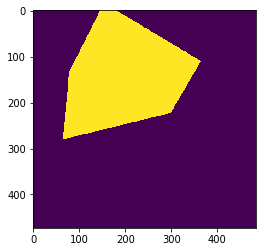

In [253]:
imshow(raster_shapefile)


In [163]:
result_masked = xarray.where(raster_shapefile)
result_masked.plot()

(1305662.5, 25.0, 0.0, -1297362.5, 0.0, -25.0)

In [178]:

nir_only_cloud_free.isel(time=image).x



# x = np.hstack(nir_only_cloud_free.isel(x=slice(0,200), time=image))
# y1 = np.hstack(red_only_cloud_free.isel(x=slice(0,200), time=image))
# y2 = np.hstack(blue_only_cloud_free.isel(x=slice(0,200), time=image))
# y3 = np.hstack(green_only_cloud_free.isel(x=slice(0,200), time=image))

<xarray.DataArray 'x' (x: 484)>
array([ 1305662.5,  1305687.5,  1305712.5, ...,  1317687.5,  1317712.5,
        1317737.5])
Coordinates:
    time     datetime64[ns] 2016-01-07T00:27:14
  * x        (x) float64 1.306e+06 1.306e+06 1.306e+06 1.306e+06 1.306e+06 ...
Attributes:
    units:    metre

In [157]:
plt.figure(GEOM)


TypeError: int() argument must be a string, a bytes-like object or a number, not 'Geometry'

## Subplot method

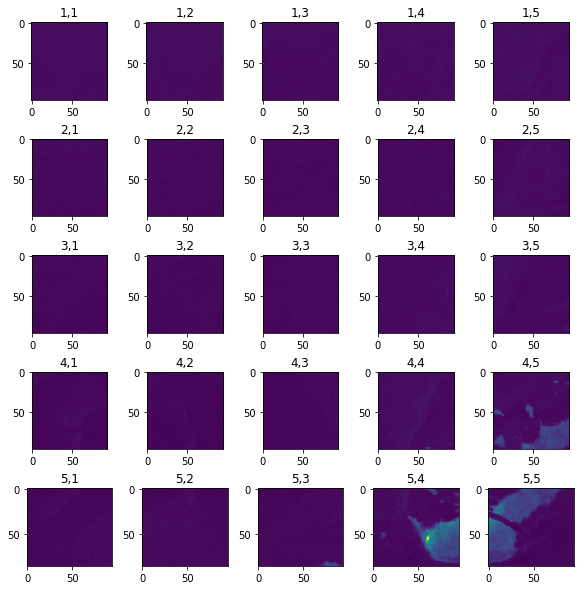

In [113]:
# Find the shape of the area of interest and plot it as multiple, labelled subplots
pixels_in_x = red_only_cloud_free.shape[0]
pixels_in_y = red_only_cloud_free.shape[1]

def break_up_plot(array,a,b):
    """function for doing an imshow thngy
    a = minimun x value for subplot, b = minimum y value for subplot """
    imshow(array.isel(x=slice((int (a*pixels_in_x)),(int ((a + 0.2)*pixels_in_x))),
                                y=slice(int (b*pixels_in_y),(int ((b + 0.2)*pixels_in_y))), time=image) , 
       vmin=np.min(array.isel(time=image)), vmax=np.max(array.isel(time=image)))


plt.figure(figsize = (10,10))
plt.subplots_adjust(hspace = 0.5)


plt.subplot(551)
plt.title ('1,1')
imshow(red_only_cloud_free.isel(x=slice(0,(int (0.2*pixels_in_x))), y=slice(0,(int (0.2*pixels_in_y))), time=image) , 
       vmin=np.min(red_only_cloud_free.isel(time=image)), vmax=np.max(red_only_cloud_free.isel(time=image)))

plt.subplot(552)
plt.title('1,2')
imshow(red_only_cloud_free.isel(x=slice((int (0.2*pixels_in_x)),(int (0.4*pixels_in_x))), 
                                y=slice(0,(int (0.2*pixels_in_y))), time=image) , 
       vmin=np.min(red_only_cloud_free.isel(time=image)), vmax=np.max(red_only_cloud_free.isel(time=image)))

plt.subplot(553)
plt.title('1,3')
imshow(red_only_cloud_free.isel(x=slice((int (0.4*pixels_in_x)),(int (0.6*pixels_in_x))), 
                                y=slice(0,(int (0.2*pixels_in_y))), time=image) , 
       vmin=np.min(red_only_cloud_free.isel(time=image)), vmax=np.max(red_only_cloud_free.isel(time=image)))

plt.subplot(554)
plt.title('1,4')
imshow(red_only_cloud_free.isel(x=slice((int (0.6*pixels_in_x)),(int (0.8*pixels_in_x))), 
                                y=slice(0,(int (0.2*pixels_in_y))), time=image) , 
       vmin=np.min(red_only_cloud_free.isel(time=image)), vmax=np.max(red_only_cloud_free.isel(time=image)))

plt.subplot(555)
plt.title('1,5')
imshow(red_only_cloud_free.isel(x=slice((int (0.8*pixels_in_x)),(int (1*pixels_in_x))), 
                                y=slice(0,(int (0.2*pixels_in_y))), time=image) , 
       vmin=np.min(red_only_cloud_free.isel(time=image)), vmax=np.max(red_only_cloud_free.isel(time=image)))

plt.subplot(556)
plt.title('2,1')
imshow(red_only_cloud_free.isel(x=slice(0,(int (0.2*pixels_in_x))), 
                                y=slice(int (0.2*pixels_in_y),(int (0.4*pixels_in_y))), time=image) , 
       vmin=np.min(red_only_cloud_free.isel(time=image)), vmax=np.max(red_only_cloud_free.isel(time=image)))

plt.subplot(557)
plt.title('2,2')
imshow(red_only_cloud_free.isel(x=slice((int (0.2*pixels_in_x)),(int (0.4*pixels_in_x))), 
                                y=slice(int (0.2*pixels_in_y),(int (0.4*pixels_in_y))), time=image) , 
       vmin=np.min(red_only_cloud_free.isel(time=image)), vmax=np.max(red_only_cloud_free.isel(time=image)))

plt.subplot(558)
plt.title('2,3')
imshow(red_only_cloud_free.isel(x=slice((int (0.4*pixels_in_x)),(int (0.6*pixels_in_x))), 
                                y=slice(int (0.2*pixels_in_y),(int (0.4*pixels_in_y))), time=image) , 
       vmin=np.min(red_only_cloud_free.isel(time=image)), vmax=np.max(red_only_cloud_free.isel(time=image)))

plt.subplot(559)
plt.title('2,4')
imshow(red_only_cloud_free.isel(x=slice((int (0.6*pixels_in_x)),(int (0.8*pixels_in_x))), 
                                y=slice(int (0.2*pixels_in_y),(int (0.4*pixels_in_y))), time=image) , 
       vmin=np.min(red_only_cloud_free.isel(time=image)), vmax=np.max(red_only_cloud_free.isel(time=image)))

plt.subplot(5, 5, 10)
plt.title('2,5')
imshow(red_only_cloud_free.isel(x=slice((int (0.8*pixels_in_x)),(int (1*pixels_in_x))), 
                                y=slice(int (0.2*pixels_in_y),(int (0.4*pixels_in_y))), time=image) , 
       vmin=np.min(red_only_cloud_free.isel(time=image)), vmax=np.max(red_only_cloud_free.isel(time=image)))

plt.subplot(5, 5, 11)
plt.title('3,1')
imshow(red_only_cloud_free.isel(x=slice(0,(int (0.2*pixels_in_x))), 
                                y=slice(int (0.4*pixels_in_y),(int (0.6*pixels_in_y))), time=image) , 
       vmin=np.min(red_only_cloud_free.isel(time=image)), vmax=np.max(red_only_cloud_free.isel(time=image)))

plt.subplot(5, 5, 12)
plt.title('3,2')
imshow(red_only_cloud_free.isel(x=slice((int (0.2*pixels_in_x)),(int (0.4*pixels_in_x))),
                                y=slice(int (0.4*pixels_in_y),(int (0.6*pixels_in_y))), time=image) , 
       vmin=np.min(red_only_cloud_free.isel(time=image)), vmax=np.max(red_only_cloud_free.isel(time=image)))

plt.subplot(5, 5, 13)
plt.title('3,3')
imshow(red_only_cloud_free.isel(x=slice((int (0.4*pixels_in_x)),(int (0.6*pixels_in_x))),
                                y=slice(int (0.4*pixels_in_y),(int (0.6*pixels_in_y))), time=image) , 
       vmin=np.min(red_only_cloud_free.isel(time=image)), vmax=np.max(red_only_cloud_free.isel(time=image)))

plt.subplot(5, 5, 14)
plt.title('3,4')
imshow(red_only_cloud_free.isel(x=slice((int (0.6*pixels_in_x)),(int (0.8*pixels_in_x))),
                                y=slice(int (0.4*pixels_in_y),(int (0.6*pixels_in_y))), time=image) , 
       vmin=np.min(red_only_cloud_free.isel(time=image)), vmax=np.max(red_only_cloud_free.isel(time=image)))

plt.subplot(5, 5, 15)
plt.title('3,5')
imshow(red_only_cloud_free.isel(x=slice((int (0.8*pixels_in_x)),(int (1*pixels_in_x))),
                                y=slice(int (0.4*pixels_in_y),(int (0.6*pixels_in_y))), time=image) , 
       vmin=np.min(red_only_cloud_free.isel(time=image)), vmax=np.max(red_only_cloud_free.isel(time=image)))

plt.subplot(5, 5, 16)
plt.title('4,1')
imshow(red_only_cloud_free.isel(x=slice(0,(int (0.2*pixels_in_x))), 
                                y=slice(int (0.6*pixels_in_y),(int (0.8*pixels_in_y))), time=image) , 
       vmin=np.min(red_only_cloud_free.isel(time=image)), vmax=np.max(red_only_cloud_free.isel(time=image)))

plt.subplot(5, 5, 17)
plt.title('4,2')
imshow(red_only_cloud_free.isel(x=slice((int (0.2*pixels_in_x)),(int (0.4*pixels_in_x))),
                                y=slice(int (0.6*pixels_in_y),(int (0.8*pixels_in_y))), time=image) , 
       vmin=np.min(red_only_cloud_free.isel(time=image)), vmax=np.max(red_only_cloud_free.isel(time=image)))

plt.subplot(5, 5, 18)
plt.title('4,3')
imshow(red_only_cloud_free.isel(x=slice((int (0.4*pixels_in_x)),(int (0.6*pixels_in_x))),
                                y=slice(int (0.6*pixels_in_y),(int (0.8*pixels_in_y))), time=image) , 
       vmin=np.min(red_only_cloud_free.isel(time=image)), vmax=np.max(red_only_cloud_free.isel(time=image)))

plt.subplot(5, 5, 19)
plt.title('4,4')
imshow(red_only_cloud_free.isel(x=slice((int (0.6*pixels_in_x)),(int (0.8*pixels_in_x))),
                                y=slice(int (0.6*pixels_in_y),(int (0.8*pixels_in_y))), time=image) , 
       vmin=np.min(red_only_cloud_free.isel(time=image)), vmax=np.max(red_only_cloud_free.isel(time=image)))

plt.subplot(5, 5, 20)
plt.title('4,5')
imshow(red_only_cloud_free.isel(x=slice((int (0.8*pixels_in_x)),(int (1*pixels_in_x))),
                                y=slice(int (0.6*pixels_in_y),(int (0.8*pixels_in_y))), time=image) , 
       vmin=np.min(red_only_cloud_free.isel(time=image)), vmax=np.max(red_only_cloud_free.isel(time=image)))

plt.subplot(5, 5, 21)
plt.title('5,1')
imshow(red_only_cloud_free.isel(x=slice(0,(int (0.2*pixels_in_x))), 
                                y=slice(int (0.8*pixels_in_y),(int (1*pixels_in_y))), time=image) , 
       vmin=np.min(red_only_cloud_free.isel(time=image)), vmax=np.max(red_only_cloud_free.isel(time=image)))

plt.subplot(5, 5, 22)
plt.title('5,2')
imshow(red_only_cloud_free.isel(x=slice((int (0.2*pixels_in_x)),(int (0.4*pixels_in_x))),
                                y=slice(int (0.8*pixels_in_y),(int (1*pixels_in_y))), time=image) , 
       vmin=np.min(red_only_cloud_free.isel(time=image)), vmax=np.max(red_only_cloud_free.isel(time=image)))

plt.subplot(5, 5, 23)
plt.title('5,3')
imshow(red_only_cloud_free.isel(x=slice((int (0.4*pixels_in_x)),(int (0.6*pixels_in_x))),
                                y=slice(int (0.8*pixels_in_y),(int (1*pixels_in_y))), time=image) , 
       vmin=np.min(red_only_cloud_free.isel(time=image)), vmax=np.max(red_only_cloud_free.isel(time=image)))

plt.subplot(5, 5, 24)
plt.title('5,4')
imshow(red_only_cloud_free.isel(x=slice((int (0.6*pixels_in_x)),(int (0.8*pixels_in_x))),
                                y=slice(int (0.8*pixels_in_y),(int (1*pixels_in_y))), time=image) , 
       vmin=np.min(red_only_cloud_free.isel(time=image)), vmax=np.max(red_only_cloud_free.isel(time=image)))

plt.subplot(5, 5, 25)
plt.title('5,5')
imshow(red_only_cloud_free.isel(x=slice((int (0.8*pixels_in_x)),(int (1*pixels_in_x))),
                                y=slice(int (0.8*pixels_in_y),(int (1*pixels_in_y))), time=image) , 
       vmin=np.min(red_only_cloud_free.isel(time=image)), vmax=np.max(red_only_cloud_free.isel(time=image)))

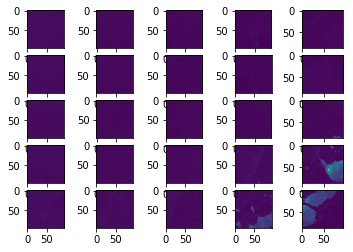

In [45]:
pixels_in_x = red_only_cloud_free.shape[0]
pixels_in_y = red_only_cloud_free.shape[1]

def break_up_plot(array,a,b):
    """function for doing an imshow thngy
    a = minimun x value for subplot, b = minimum y value for subplot """
    imshow(array.isel(x=slice((int (a*pixels_in_x)),(int ((a + 0.2)*pixels_in_x))),
                                y=slice(int (b*pixels_in_y),(int ((b + 0.2)*pixels_in_y))), time=image) , 
       vmin=np.min(array.isel(time=image)), vmax=np.max(array.isel(time=image)))
    
for i in range(5):
    for j in range(5):
        plt.subplot(5, 5, i * 5 + j + 1)
        break_up_plot(red_only_cloud_free, i * 0.2, j * 0.2)

### Make check boxes next to images...

## Identify glint

### Plot r,b, or g against nir and calculate a linear best fit line

red gradient:    0.906222606258
red y-intercept: 40.5956523642
blue gradient:    1.32734531673
blue y-intercept: 217.205313632
green gradient:    1.05282101661
green y-intercept: 115.431994074


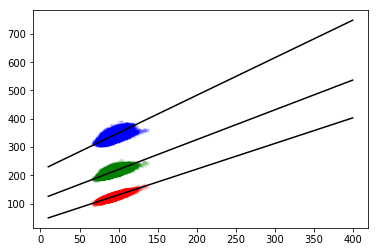

In [10]:
# Define x and y for plotting as 1D arrays - WHERE ALL DEEP OCEAN
# x = np.hstack(nir_only_cloud_free.isel(time=image))
# y1 = np.hstack(red_only_cloud_free.isel(time=image))
# y2 = np.hstack(blue_only_cloud_free.isel(time=image))
# y3 = np.hstack(green_only_cloud_free.isel(time=image))

# Define x and y for plotting as 1D arrays - WHERE PARTIALLY DEEP OCEAN
x = np.hstack(nir_only_cloud_free.isel(x=slice(0,200), time=image))
y1 = np.hstack(red_only_cloud_free.isel(x=slice(0,200), time=image))
y2 = np.hstack(blue_only_cloud_free.isel(x=slice(0,200), time=image))
y3 = np.hstack(green_only_cloud_free.isel(x=slice(0,200), time=image))

# Calculate linear best fit line
red_model = LinearRegression()
blue_model = LinearRegression()
green_model = LinearRegression()

red_model.fit(x[:, np.newaxis], y1)
blue_model.fit(x[:, np.newaxis], y2)
green_model.fit(x[:, np.newaxis], y3)

# Define x and y values for the best fit line
xfit = np.linspace(10,400)
y1fit = red_model.predict(xfit[:, np.newaxis])
y2fit = blue_model.predict(xfit[:, np.newaxis])
y3fit = green_model.predict(xfit[:, np.newaxis])

# Plot the data and the best fit line
plt.scatter(x, y1, s = 10, color = 'red', alpha = 0.1)
plt.plot(xfit, y1fit, color = 'black')

plt.scatter(x, y2, s = 10, color = 'blue', alpha = 0.1)
plt.plot(xfit, y2fit, color = 'black')

plt.scatter(x, y3, s = 10, color = 'green', alpha = 0.1)
plt.plot(xfit, y3fit, color = 'black')

# Print gradient and y-intercept
print("red gradient:   ", red_model.coef_[0])
print("red y-intercept:", red_model.intercept_)

print("blue gradient:   ", blue_model.coef_[0])
print("blue y-intercept:", blue_model.intercept_)

print("green gradient:   ", green_model.coef_[0])
print("green y-intercept:", green_model.intercept_)

### Calculate and plot the degree of glint for each pixel

<xarray.DataArray (y: 473, x: 484)>
array([[ 70.175718,  71.525251,  74.224317, ...,  74.224317,  79.622449,
         79.622449],
       [ 71.525251,  74.224317,  75.57385 , ...,  70.175718,  82.321515,
         78.272916],
       [ 67.476652,  70.175718,  70.175718, ...,  70.175718,  78.272916,
         70.175718],
       ..., 
       [ 43.185057,  35.087859,  33.738326, ...,  48.583189,  45.884123,
         51.282255],
       [ 43.185057,  39.136458,  37.786925, ...,  44.53459 ,  41.835524,
         47.233656],
       [ 43.185057,  41.835524,  43.185057, ...,  41.835524,  39.136458,
         41.835524]])
Coordinates:
    time     datetime64[ns] 2016-01-07T00:27:14
  * y        (y) float64 -1.297e+06 -1.297e+06 -1.297e+06 -1.297e+06 ...
  * x        (x) float64 1.306e+06 1.306e+06 1.306e+06 1.306e+06 1.306e+06 ...


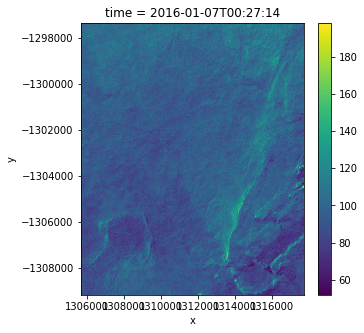

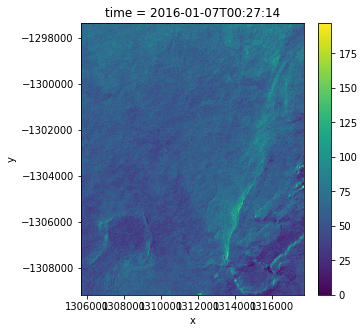

In [11]:
# Proxy for glint: degree_of_glint = absolute length of line parallel to slope of best fit line (above). 
# This is found using trig - first term is distance between pixel value and min(nir) along x-axis,
# second term is the cosine of the angle between horizontal and best fit line

degree_of_glint = ((nir_only_cloud_free.isel(time=image))-(nir_only_cloud_free.isel(time=image).min()))/np.cos(np.deg2rad(np.rad2deg(np.arctan(red_model.coef_[0]))))
print(degree_of_glint)
# Plot map of degree of glint
nir_only_cloud_free.isel(time=image).plot(figsize=(5,5))
degree_of_glint.plot(figsize=(5,5))

## Correct for glint in r,g,b using the Hedley method

In [12]:
# Apply the Hedley correction to the cloud free data for the r,g,b data
red_corr = red_only_cloud_free.isel(time=image)-((red_model.coef_[0])*((nir_only_cloud_free.isel(time=image))-(nir_only_cloud_free.isel(x=slice(0,200),time=image).min())))
blue_corr = blue_only_cloud_free.isel(time=image)-((blue_model.coef_[0])*((nir_only_cloud_free.isel(time=image))-(nir_only_cloud_free.isel(x=slice(0,200),time=image).min())))
green_corr = green_only_cloud_free.isel(time=image)-((green_model.coef_[0])*((nir_only_cloud_free.isel(time=image))-(nir_only_cloud_free.isel(x=slice(0,200),time=image).min())))
print (red_corr)

<xarray.DataArray (y: 473, x: 484)>
array([[ 106.563541,  107.657318,  103.844873, ...,  105.844873,  104.219983,
          99.219983],
       [ 103.657318,  106.844873,  103.938651, ...,  107.563541,  101.407538,
         100.126205],
       [ 101.375986,  103.563541,  101.563541, ...,  106.563541,  100.126205,
         100.563541],
       ..., 
       [  97.687993,  101.125329,  101.031551, ...,  103.063103,  103.875548,
          99.250657],
       [  96.687993,  100.406661,  103.312884, ...,  101.78177 ,  102.594216,
          98.969325],
       [  99.687993,  102.594216,  101.687993, ...,   96.594216,  101.406661,
         101.594216]])
Coordinates:
    time     datetime64[ns] 2016-01-07T00:27:14
  * y        (y) float64 -1.297e+06 -1.297e+06 -1.297e+06 -1.297e+06 ...
  * x        (x) float64 1.306e+06 1.306e+06 1.306e+06 1.306e+06 1.306e+06 ...


In [13]:
# Create nir_corr - an array of the same shape as nir_only_cloud_free (etc.) where all values equal nir_only_cloud_free.min()
nir_corr = red_corr/red_corr*nir_only_cloud_free.isel(x=slice(0,200),time=image).min()

## Plot wavelength v intensity

### For one column or row of pixels in an area

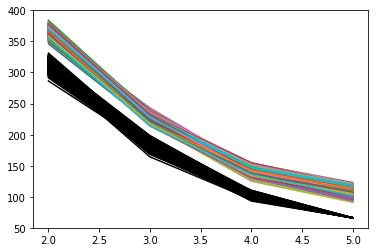

In [14]:
# Select an x range, y-value and time to look at pixels from
pixels = data.isel(x=slice(0,470),y=10,time=0)

# Create a horizontal 1D array for the Landsat bands
landsat_bands = np.array([2,3,4,5])

# Plot r,g,b,nir bands v intensity for all pixels in x range (raw, raw cloud free, and corrected)
for i in range (470):
    #plt.plot(landsat_bands,np.vstack((pixels.blue, pixels.green, pixels.red, pixels.nir))[:,i])
    plt.plot(landsat_bands,np.vstack((blue_only_cloud_free.isel(x=slice(0,470),y=10,time=image), green_only_cloud_free.isel(x=slice(0,470),y=10,time=image), red_only_cloud_free.isel(x=slice(0,470),y=10,time=image), nir_only_cloud_free.isel(x=slice(0,470),y=10,time=image)))[:,i])
    plt.plot(landsat_bands,np.vstack((blue_corr.isel(x=slice(0,470),y=10), green_corr.isel(x=slice(0,470),y=10), red_corr.isel(x=slice(0,470),y=10), nir_corr.isel(x=slice(0,470),y=10)))[:,i], color = 'black')

### For max and min nir intensities in the area

In [15]:
# Take the uncorrected data, and sepeartely the corrected data, and create an array for each, where each band and degree of 
# glint values are stacked into 1D arrays and then transposed to create a 2D array. 

# Uncorrected data:
nir_uncorr_stacked = np.hstack(nir_only_cloud_free.isel(x=slice(0,200),time=image))
red_uncorr_stacked = np.hstack(red_only_cloud_free.isel(x=slice(0,200),time=image))
blue_uncorr_stacked = np.hstack(blue_only_cloud_free.isel(x=slice(0,200),time=image))
green_uncorr_stacked = np.hstack(green_only_cloud_free.isel(x=slice(0,200),time=image))
degree_of_glint_stacked = np.hstack(degree_of_glint.isel(x=slice(0,200)))
all_uncorr = np.transpose(np.vstack((blue_uncorr_stacked, green_uncorr_stacked, red_uncorr_stacked, nir_uncorr_stacked, degree_of_glint_stacked)))
print (all_uncorr)

# Corrected data:
nir_corr_stacked = np.hstack(nir_corr.isel(x=slice(0,200)))
red_corr_stacked = np.hstack(red_corr.isel(x=slice(0,200)))
blue_corr_stacked = np.hstack(blue_corr.isel(x=slice(0,200)))
green_corr_stacked = np.hstack(green_corr.isel(x=slice(0,200)))
degree_of_glint_stacked = np.hstack(degree_of_glint.isel(x=slice(0,200)))
all_corr = np.transpose(np.vstack((blue_corr_stacked, green_corr_stacked, red_corr_stacked, nir_corr_stacked, degree_of_glint_stacked)))
print (all_corr)

[[ 366.          231.          141.          104.           70.17571781]
 [ 364.          232.          143.          105.           71.52525085]
 [ 359.          233.          141.          107.           74.22431692]
 ..., 
 [ 337.          212.          127.           96.           59.37945353]
 [ 332.          210.          127.           96.           59.37945353]
 [ 335.          212.          128.           95.           58.0299205 ]]
[[ 315.56087796  190.99280137  106.56354096   66.           70.17571781]
 [ 312.23353265  190.93998035  107.65731836   66.           71.52525085]
 [ 304.57884201  189.83433832  103.84487314   66.           74.22431692]
 ..., 
 [ 297.1796405   180.4153695    99.81332181   66.           59.37945353]
 [ 292.1796405   178.4153695    99.81332181   66.           59.37945353]
 [ 296.50698581  181.46819052  101.71954442   66.           58.0299205 ]]


In [16]:
# Order the rows of the two matricies from min-max degree_of_glint
all_uncorr_ordered = all_uncorr[all_uncorr[:,4].argsort()]
all_corr_ordered = all_corr[all_corr[:,4].argsort()]
print (all_uncorr_ordered)
print (all_corr_ordered)

# Check that the ordering has worked by finding the max nir value in all_corr and seeing what thr rgb values are for 
# that pixel
all_corr[np.where(all_corr[:,4] == all_corr[:,4].max())]

[[ 310.          188.          103.           66.           18.89346249]
 [ 316.          195.          101.           67.           20.24299552]
 [ 314.          182.           96.           68.           21.59252856]
 ..., 
 [ 359.          237.          156.          134.          110.66170886]
 [ 360.          243.          162.          136.          113.36077493]
 [ 360.          243.          162.          136.          113.36077493]]
[[ 310.          188.          103.           66.           18.89346249]
 [ 314.67265468  193.94717898  100.09377739   66.           20.24299552]
 [ 311.34530937  179.89435797   94.18755479   66.           21.59252856]
 ..., 
 [ 268.74051846  165.40817087   94.37686277   66.          110.66170886]
 [ 267.08582783  169.30252884   98.56441756   66.          113.36077493]
 [ 267.08582783  169.30252884   98.56441756   66.          113.36077493]]


array([[ 267.08582783,  169.30252884,   98.56441756,   66.        ,
         113.36077493],
       [ 267.08582783,  169.30252884,   98.56441756,   66.        ,
         113.36077493]])

In [17]:
# Take to values from each of the two matricies where degree_of_glint values are lowest and highest. 
minmax_uncorr = np.vstack(((all_uncorr_ordered[:100,:4]),(all_uncorr_ordered[-100:,:4])))
minmax_corr = np.vstack(((all_corr_ordered[:100,:4]),(all_corr_ordered[-100:,:4])))
print (minmax_uncorr)

[[ 310.  188.  103.   66.]
 [ 316.  195.  101.   67.]
 [ 314.  182.   96.   68.]
 [ 315.  189.  104.   68.]
 [ 321.  187.  100.   68.]
 [ 315.  188.  103.   68.]
 [ 314.  182.   96.   68.]
 [ 317.  189.   99.   68.]
 [ 315.  188.  102.   69.]
 [ 320.  190.  105.   69.]
 [ 313.  187.  102.   69.]
 [ 311.  189.  101.   69.]
 [ 310.  187.  105.   70.]
 [ 314.  190.  102.   70.]
 [ 318.  192.  105.   70.]
 [ 312.  185.  102.   70.]
 [ 320.  191.  109.   70.]
 [ 320.  188.  103.   70.]
 [ 315.  196.  108.   71.]
 [ 311.  184.   98.   71.]
 [ 316.  193.  107.   71.]
 [ 319.  195.  108.   71.]
 [ 318.  196.  110.   71.]
 [ 314.  192.  106.   71.]
 [ 318.  189.  100.   71.]
 [ 317.  192.  105.   71.]
 [ 319.  191.  107.   71.]
 [ 314.  189.  106.   71.]
 [ 318.  193.   98.   71.]
 [ 308.  196.  108.   71.]
 [ 317.  193.  105.   71.]
 [ 321.  196.  105.   71.]
 [ 326.  197.  109.   71.]
 [ 318.  192.  102.   71.]
 [ 317.  195.  106.   72.]
 [ 322.  195.  110.   72.]
 [ 316.  188.  105.   72.]
 

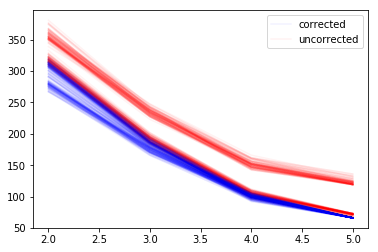

In [31]:
# Plot both the uncorrected data (red) and the corrected data (blue)

for i in range (200):
    plt.plot(landsat_bands, (np.transpose(minmax_corr))[:,i], color = 'blue', alpha = 0.05, label = "corrected")
    plt.plot(landsat_bands, (np.transpose(minmax_uncorr))[:,i], color = 'red', alpha = 0.05, label = "uncorrected")
    plt.legend()


## Load true-colour images to show glint removal

Bex's colour notebook
https://github.com/GeoscienceAustralia/dea-notebooks/blob/BexDunn/workflows/Retrieve_Landsat_plot_false_color_190218.ipynb

Other websites from Bex:
All about colour things in scikit... http://scikit-image.org/docs/dev/user_guide/transforming_image_data.html
Loading colours in GDAL: https://pcjericks.github.io/py-gdalogr-cookbook/raster_layers.html#clip-a-geotiff-with-shapefile
Random colour-related things:
https://stackoverflow.com/questions/42991524/how-to-optimize-this-image-iteration-in-numpy
https://www.programcreek.com/python/example/71304/cv2.COLOR_BGR2RGB

### Create datasets from data arrays

In [41]:
# Create a dataset of rgb only_cloud_free.isel(time=image) data arrays
red_only_cloud_free = xr.DataArray(red_only_cloud_free.isel(time=image), name = 'red_only_cloud_free')
blue_only_cloud_free = xr.DataArray(blue_only_cloud_free.isel(time=image), name = 'blue_only_cloud_free')
green_only_cloud_free = xr.DataArray(green_only_cloud_free.isel(time=image), name = 'green_only_cloud_free')
nir_only_cloud_free = xr.DataArray(nir_only_cloud_free.isel(time=image), name = 'nir_only_cloud_free')
dataset_only_cloud_free = xr.merge([red_only_cloud_free, green_only_cloud_free, blue_only_cloud_free, nir_only_cloud_free])


# Create a dataset of rgb corr data arrays
red_corr = xr.DataArray(red_corr, name = 'red_corr')
blue_corr = xr.DataArray(blue_corr, name = 'blue_corr')
green_corr = xr.DataArray(green_corr, name = 'green_corr')
nir_corr = xr.DataArray(nir_corr, name = 'nir_corr')
dataset_corr = xr.merge([red_corr, green_corr, blue_corr, nir_corr])

### Plot true-colour images with and without glint

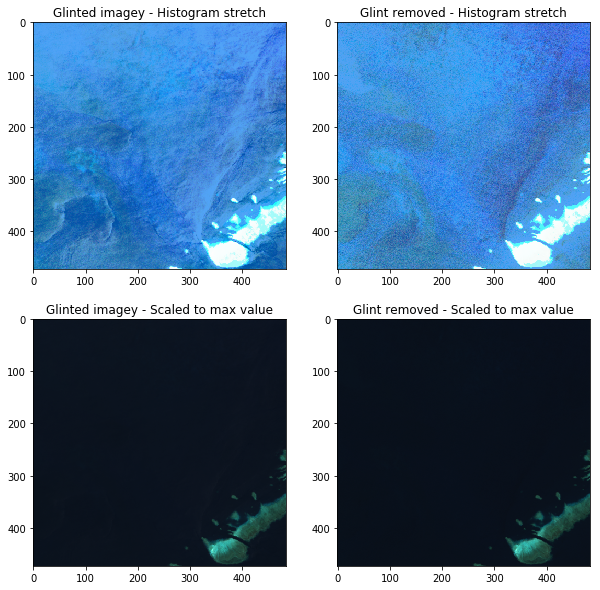

In [42]:
# HISTOGRAM STRETCH IMAGES
# Draw image with sun glint
def drawTrueColourHist(ds):
    '''this function takes the shape of an input band and uses swir1, nir and green to make and display a false
    color composite. Written by Mike Barnes, edited by Bex Dunn and Claire Krause'''
    y, x = ds['red_only_cloud_free'].shape
    rawimg = np.zeros((y,x,3), dtype = np.float32)
    for i, colour in enumerate(['red_only_cloud_free', 'green_only_cloud_free', 'blue_only_cloud_free']):
        rawimg[:,:,i] = ds[colour].values
    rawimg[rawimg == -999] = np.nan
    img_toshow1 = exposure.equalize_hist(rawimg, mask = np.isfinite(rawimg))
    return img_toshow1


# Draw image with no sun glint
def drawTrueColourNoGlintHist(ds):
    '''this function takes the shape of an input band and uses swir1, nir and green to make and display a false
    color composite. Written by Mike Barnes, edited by Bex Dunn and Claire Krause'''
    y, x = ds['red_corr'].shape
    rawimg = np.zeros((y,x,3), dtype = np.float32)
    for i, colour in enumerate(['red_corr', 'green_corr', 'blue_corr']):
        rawimg[:,:,i] = ds[colour].values
    rawimg[rawimg == -999] = np.nan
    img_toshow2 = exposure.equalize_hist(rawimg, mask = np.isfinite(rawimg))
    return img_toshow2

# SCALED TO MAX VAL IMAGES
# Draw image with sun glint
def drawTrueColourScaled(ds):
    '''this function takes the shape of an input band and uses swir1, nir and green to make and display a false
    color composite. Written by Mike Barnes, edited by Bex Dunn and Claire Krause'''
    y, x = ds['red_only_cloud_free'].shape
    rawimg = np.zeros((y,x,3), dtype = np.float32)
    for i, colour in enumerate(['red_only_cloud_free', 'green_only_cloud_free', 'blue_only_cloud_free']):
        rawimg[:,:,i] = ds[colour].values
    rawimg[rawimg == -999] = np.nan
    img_toshow3 = rawimg/rawimg.max()
    return img_toshow3

# Draw image with no sun glint
def drawTrueColourNoGlintScaled(ds):
    '''this function takes the shape of an input band and uses swir1, nir and green to make and display a false
    color composite. Written by Mike Barnes, edited by Bex Dunn and Claire Krause'''
    y, x = ds['red_corr'].shape
    rawimg = np.zeros((y,x,3), dtype = np.float32)
    for i, colour in enumerate(['red_corr', 'green_corr', 'blue_corr']):
        rawimg[:,:,i] = ds[colour].values
    rawimg[rawimg == -999] = np.nan
    img_toshow4 = rawimg/rawimg.max()
    return img_toshow4


# Plot rgb glinted images and rgb images with glint removed, using a histogram stretch and by scaling intensities to maximum values
plt.figure(figsize = (10,10))
plt.subplot(221)
plt.title ('Glinted imagey - Histogram stretch')
imshow(drawTrueColourHist(dataset_only_cloud_free))
plt.subplot(222)
plt.title('Glint removed - Histogram stretch')
imshow(drawTrueColourNoGlintHist(dataset_corr))
plt.subplot(223)
plt.title ('Glinted imagey - Scaled to max value')
imshow(drawTrueColourScaled(dataset_only_cloud_free))
plt.subplot(224)
plt.title('Glint removed - Scaled to max value')
imshow(drawTrueColourNoGlintScaled(dataset_corr))

## Export Geotiff

In [19]:
# Import neccesary code
% pylab notebook

import sys
import os
sys.path.append(os.path.abspath('/g/data/r78/cek156/dea-notebooks/algorithms'))
import DEAPlotting
import DEADataHandling

# Now just some regular module imports
from datacube import Datacube
from datetime import datetime

dc = Datacube(app = 'test')

Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


<IPython.core.display.Javascript object>


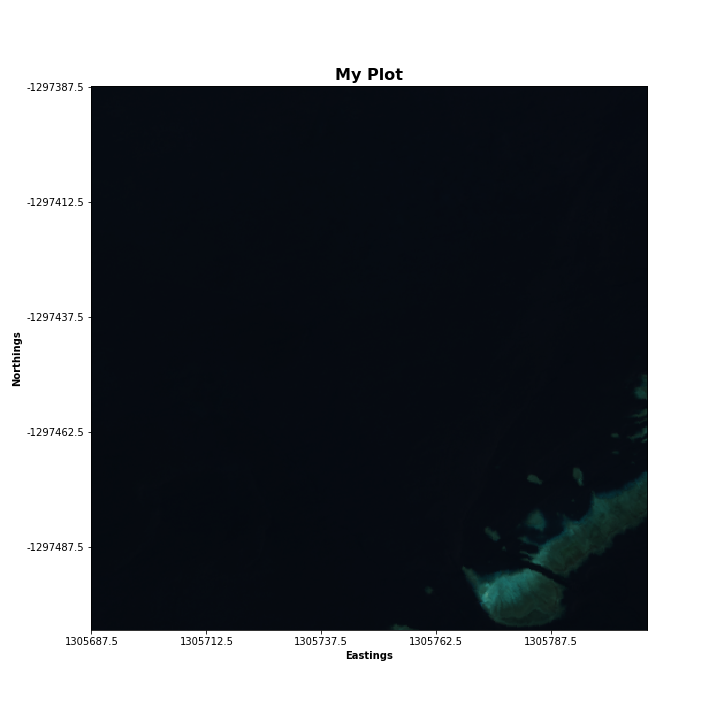

(<module 'matplotlib.pyplot' from '/g/data/v10/public/modules/agdc-py3-env/20171214/envs/agdc/lib/python3.6/site-packages/matplotlib/pyplot.py'>,
 <matplotlib.figure.Figure at 0x7f739f298a20>)

In [49]:
# Plot a three-band image of the uncorrected data
% pylab notebook
DEAPlotting.three_band_image(dataset_only_cloud_free, ['red_only_cloud_free','green_only_cloud_free','blue_only_cloud_free'])

Populating the interactive namespace from numpy and matplotlib


<IPython.core.display.Javascript object>


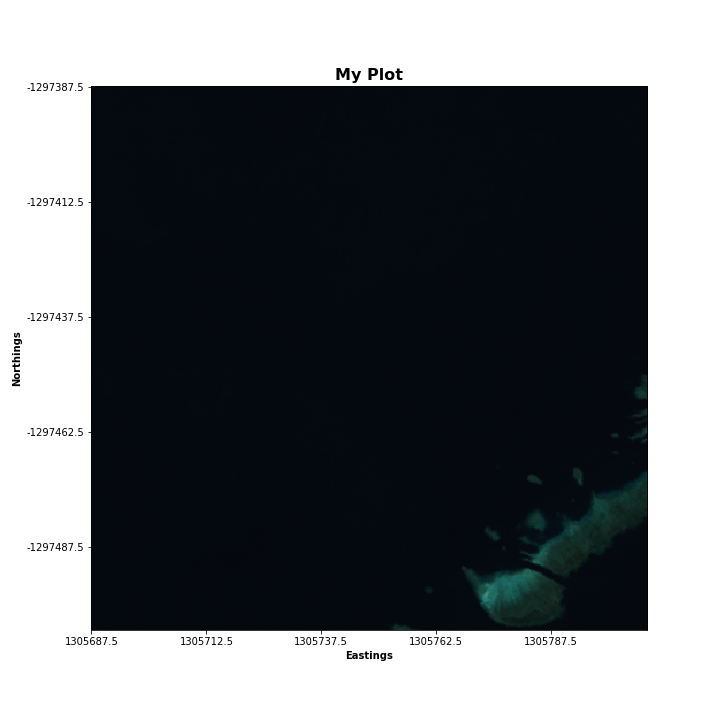

(<module 'matplotlib.pyplot' from '/g/data/v10/public/modules/agdc-py3-env/20171214/envs/agdc/lib/python3.6/site-packages/matplotlib/pyplot.py'>,
 <matplotlib.figure.Figure at 0x7f739f41a4e0>)

In [47]:
# Plot a three-band image of the corrected data
% pylab notebook
DEAPlotting.three_band_image(dataset_corr, ['red_corr','green_corr','blue_corr'])

In [50]:
# Export Geotiffs

# Uncorrected data
dataset_only_cloud_free.attrs['crs'] = data.crs
DEADataHandling.dataset_to_geotiff('uncorrected.tif', dataset_only_cloud_free)

# Corrected data
dataset_corr.attrs['crs'] = data.crs
DEADataHandling.dataset_to_geotiff('corrected.tif', dataset_corr)